# Stjerner og Planeter Projekt 1: BurnMan

## Introduction

I dette projekt skal I arbejde med Python programpakken [BurnMan](https://github.com/geodynamics/burnman). I skal derfor starte med at clone programpakken fra Github over på jeres egen computer. Dette kan gøres ved at åbne en Terminal i Jupyter Notebook og skrive kommandoen 'git clone https://github.com/geodynamics/burnman'. Det er vigtigt, at den mappe der hedder 'burnman' som denne komando laver ligger i din python arbejdsmappe.

Det kan evt blive nødvendigt for dig at installere et par pakker så som scipy, sympy mv. Dette kan gøres gennem Anaconda eller gennem en terminal med pip.

Nedenfor vil jeg gennemgå, hvordan man laver en planet der minder om Jorden med Burnman og plotter temperatur, tyngdeacceleration, tryk og tæthed. Denne notebook er baseret på programmet 'example_build_planet.py' der kommer med Burnman.

In [1]:
from __future__ import absolute_import
from __future__ import print_function

#impoter burnman
import sys
sys.path.insert(1,"burnman")

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

import burnman
import burnman.mineral_helpers as helpers

if __name__ == '__main__':
    # FIRST: we must define the composition of the planet as individual layers.
    # A layer is defined by 4 parameters: Name, min_depth, max_depth,and number of slices within the layer.
    # Separately the composition and the temperature_mode need to set.
    radius_planet = 6371.e3
    # inner_core
    inner_core = burnman.Layer('inner core', radii = np.linspace(0,1220.e3,10))
    inner_core.set_material(burnman.minerals.other.Fe_Dewaele())
    
    # The minerals that make up our core do not currently implement the thermal equation of state, so we will set the temperature at 300 K.
    inner_core.set_temperature_mode('user-defined',
        300.*np.ones_like(inner_core.radii))

    # outer_core
    outer_core = burnman.Layer('outer core', radii = np.linspace(1220.e3,3480.e3,10))
    outer_core.set_material(burnman.minerals.other.Liquid_Fe_Anderson())
    # The minerals that make up our core do not currently implement the thermal equation of state, so we will define the temperature at 300 K.
    outer_core.set_temperature_mode('user-defined', 300.*np.ones_like(outer_core.radii))

    # Next the Mantle.
    lower_mantle = burnman.Layer('lower mantle', radii = np.linspace(3480.e3, 5711.e3, 10))
    lower_mantle.set_material(burnman.minerals.SLB_2011.mg_bridgmanite())
    lower_mantle.set_temperature_mode('adiabatic')
    upper_mantle = burnman.Layer('upper mantle', radii = np.linspace(5711.e3, 6371e3, 10))
    upper_mantle.set_material(burnman.minerals.SLB_2011.forsterite())
    upper_mantle.set_temperature_mode('adiabatic', temperature_top = 1200.)



    # Now we calculate the planet.
    planet_zog = burnman.Planet('Planet Zog',
                                [inner_core, outer_core, lower_mantle, upper_mantle],
                                verbose=True)
    print(planet_zog)
    
    # Here we compute its state. Go BurnMan Go!
    # (If we were to change composition of one of the layers, we would have to
    # recompute the state)
    planet_zog.make()
    
    # Now we output the mass of the planet and moment of inertia
    print('\nmass/Earth= {0:.3f}, moment of inertia factor= {1:.4f}'.format(planet_zog.mass / 5.97e24,
                                                                          planet_zog.moment_of_inertia_factor))
    
    # And here's the mass of the individual layers:
    for layer in planet_zog.layers:
        print('{0} mass fraction of planet {1:.3f}'.format(layer.name, layer.mass / planet_zog.mass))
    print('')

Planet Zog consists of 4 layers:
The inner core is made of Fe_Dewaele with user-defined temperatures and self-consistent pressures
The outer core is made of Liquid_Fe_Anderson with user-defined temperatures and self-consistent pressures
The lower mantle is made of Mg_Perovskite with adiabatic temperatures and self-consistent pressures
The upper mantle is made of Forsterite with adiabatic temperatures and self-consistent pressures

Iteration 1 maximum relative pressure error: 9.6e-01
Iteration 2 maximum relative pressure error: 4.6e-01
Iteration 3 maximum relative pressure error: 1.8e-01
Iteration 4 maximum relative pressure error: 6.6e-02
Iteration 5 maximum relative pressure error: 2.3e-02
Iteration 6 maximum relative pressure error: 8.3e-03
Iteration 7 maximum relative pressure error: 2.9e-03
Iteration 8 maximum relative pressure error: 1.0e-03
Iteration 9 maximum relative pressure error: 3.6e-04
Iteration 10 maximum relative pressure error: 1.3e-04
Iteration 11 maximum relative pres

## Samligning med PREM

Vi vil nu gerne sammenligne vores resultater med de bedste værdier vi har for Jorden. Disse værdier kommer fra den såkaldte "Preliminary Reference Earth Model" (PREM). 

In [3]:
    # Let's get PREM to compare everything to as we are trying
    # to imitate Earth
    prem = burnman.seismic.PREM()
    premradii = 6371.e3 - prem.internal_depth_list()
    premdensity, prempressure, premgravity,premvs,premvp = prem.evaluate(
        ['density', 'pressure', 'gravity', 'v_s','v_p'])

## Visualisering
Derefter kan vi plotte vores resultater og PREM.

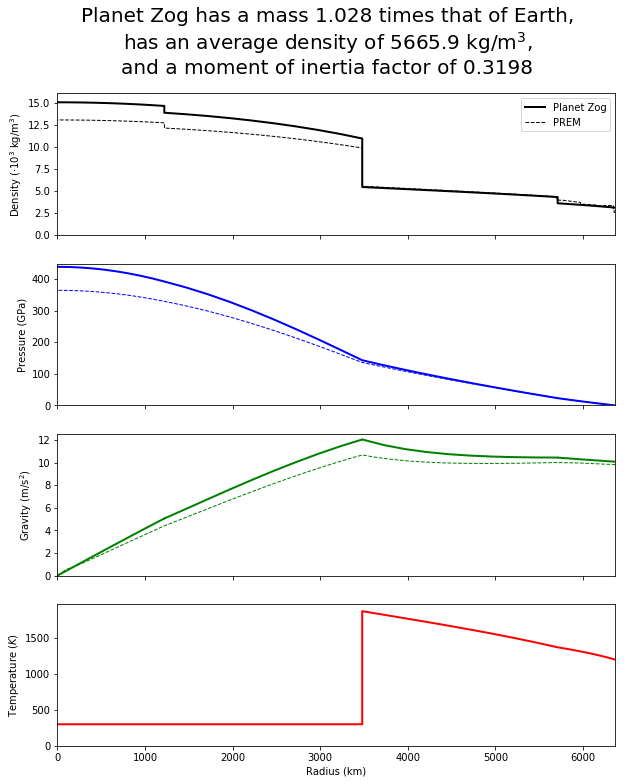

In [4]:
figure = plt.figure(figsize=(10, 12))
figure.suptitle(
        '{0} has a mass {1:.3f} times that of Earth,\n'
        'has an average density of {2:.1f} kg/m$^3$,\n'
        'and a moment of inertia factor of {3:.4f}'.format(
            planet_zog.name,
            planet_zog.mass/5.97e24,
            planet_zog.average_density,
            planet_zog.moment_of_inertia_factor),
            fontsize=20)

ax = [figure.add_subplot(4, 1, i) for i in range(1, 5)]

ax[0].plot(planet_zog.radii / 1.e3, planet_zog.density / 1.e3, 'k', linewidth=2.,
               label=planet_zog.name)
ax[0].plot( premradii / 1.e3, premdensity / 1.e3, '--k', linewidth=1., label='PREM')
ax[0].set_ylim(0., (max(planet_zog.density) / 1.e3) + 1.)
ax[0].set_ylabel('Density ($\cdot 10^3$ kg/m$^3$)')
ax[0].legend()

# Make a subplot showing the calculated pressure profile
ax[1].plot(planet_zog.radii / 1.e3, planet_zog.pressure / 1.e9, 'b', linewidth=2.)
ax[1].plot(premradii / 1.e3, prempressure / 1.e9, '--b', linewidth=1.)
ax[1].set_ylim(0., (max(planet_zog.pressure) / 1e9) + 10.)
ax[1].set_ylabel('Pressure (GPa)')

# Make a subplot showing the calculated gravity profile
ax[2].plot(planet_zog.radii / 1.e3, planet_zog.gravity, 'g', linewidth=2.)
ax[2].plot(premradii / 1.e3, premgravity, '--g', linewidth=1.)
ax[2].set_ylabel('Gravity (m/s$^2)$')
ax[2].set_ylim(0., max(planet_zog.gravity) + 0.5)

# Make a subplot showing the calculated temperature profile
ax[3].plot(planet_zog.radii / 1.e3, planet_zog.temperature, 'r', linewidth=2.)
ax[3].set_ylabel('Temperature ($K$)')
ax[3].set_xlabel('Radius (km)')
ax[3].set_ylim(0., max(planet_zog.temperature) + 100)

for i in range(3):
    ax[i].set_xticklabels([])
for i in range(4):
    ax[i].set_xlim(0., max(planet_zog.radii) / 1.e3)

## Fri leg
I kan nu prøve at lege lidt med parameterne. F.eks. gøre kernen dobbelt så stor: 

In [5]:
    inner_core = burnman.Layer('inner core', radii = np.linspace(0,2440.e3,10))
    inner_core.set_material(burnman.minerals.other.Fe_Dewaele())
    
    inner_core.set_temperature_mode('user-defined',
        300.*np.ones_like(inner_core.radii))

    outer_core = burnman.Layer('outer core', radii = np.linspace(2440.e3,3480.e3,10))
    outer_core.set_material(burnman.minerals.other.Liquid_Fe_Anderson())
    outer_core.set_temperature_mode('user-defined', 300.*np.ones_like(outer_core.radii))
    
    planet_zog = burnman.Planet('Planet Zog',
                                [inner_core, outer_core, lower_mantle, upper_mantle],
                                verbose=True)
    planet_zog.make()

Iteration 1 maximum relative pressure error: 9.7e-01
Iteration 2 maximum relative pressure error: 4.4e-01
Iteration 3 maximum relative pressure error: 1.7e-01
Iteration 4 maximum relative pressure error: 6.4e-02
Iteration 5 maximum relative pressure error: 2.3e-02
Iteration 6 maximum relative pressure error: 8.1e-03
Iteration 7 maximum relative pressure error: 2.8e-03
Iteration 8 maximum relative pressure error: 1.0e-03
Iteration 9 maximum relative pressure error: 3.5e-04
Iteration 10 maximum relative pressure error: 1.2e-04
Iteration 11 maximum relative pressure error: 4.4e-05
Iteration 12 maximum relative pressure error: 1.5e-05
Iteration 13 maximum relative pressure error: 5.4e-06


og plot

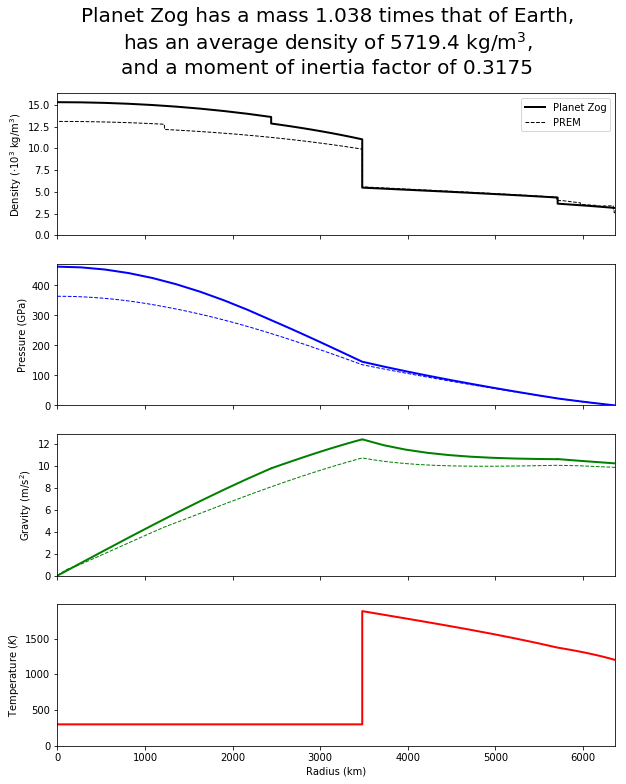

In [6]:
figure = plt.figure(figsize=(10, 12))
figure.suptitle(
        '{0} has a mass {1:.3f} times that of Earth,\n'
        'has an average density of {2:.1f} kg/m$^3$,\n'
        'and a moment of inertia factor of {3:.4f}'.format(
            planet_zog.name,
            planet_zog.mass/5.97e24,
            planet_zog.average_density,
            planet_zog.moment_of_inertia_factor),
            fontsize=20)

ax = [figure.add_subplot(4, 1, i) for i in range(1, 5)]

ax[0].plot(planet_zog.radii / 1.e3, planet_zog.density / 1.e3, 'k', linewidth=2.,
               label=planet_zog.name)
ax[0].plot( premradii / 1.e3, premdensity / 1.e3, '--k', linewidth=1., label='PREM')
ax[0].set_ylim(0., (max(planet_zog.density) / 1.e3) + 1.)
ax[0].set_ylabel('Density ($\cdot 10^3$ kg/m$^3$)')
ax[0].legend()

# Make a subplot showing the calculated pressure profile
ax[1].plot(planet_zog.radii / 1.e3, planet_zog.pressure / 1.e9, 'b', linewidth=2.)
ax[1].plot(premradii / 1.e3, prempressure / 1.e9, '--b', linewidth=1.)
ax[1].set_ylim(0., (max(planet_zog.pressure) / 1e9) + 10.)
ax[1].set_ylabel('Pressure (GPa)')

# Make a subplot showing the calculated gravity profile
ax[2].plot(planet_zog.radii / 1.e3, planet_zog.gravity, 'g', linewidth=2.)
ax[2].plot(premradii / 1.e3, premgravity, '--g', linewidth=1.)
ax[2].set_ylabel('Gravity (m/s$^2)$')
ax[2].set_ylim(0., max(planet_zog.gravity) + 0.5)

# Make a subplot showing the calculated temperature profile
ax[3].plot(planet_zog.radii / 1.e3, planet_zog.temperature, 'r', linewidth=2.)
ax[3].set_ylabel('Temperature ($K$)')
ax[3].set_xlabel('Radius (km)')
ax[3].set_ylim(0., max(planet_zog.temperature) + 100)

for i in range(3):
    ax[i].set_xticklabels([])
for i in range(4):
    ax[i].set_xlim(0., max(planet_zog.radii) / 1.e3)

## Merkur
Prøv nu, at omskriv programmet til at lave en model af Merkur.

Ud fra figur 9.11 kan I antage, at Merkur, lige som Jorden består af en fast og en flydende kerne. Antag, f.eks. at den faste kerne har en radius på 600 km, mens den flydende har en radius på 1800 km. 

Antag endvidere, at Merkur, lige som Jorden har en todelt kappe, hvor den nederste består af perovskite og den øverste består af forsterite. 

Sammenlign jeres resultater med, hvad I f.eks. kan finde på Wikipedia.

Hvis I syndes jeres resultat passer dårligt, så overvej hvilke inputparametre I kan ændre.

## Venus og Mars
Lav samme øvelse for Venus og Mars.

Her kan I f.eks. starte med at antage, at Venus har en flyende kerne, mens Mars har en fast, hvis radius udgør halvdelen af planeternes.  Kappen kan I i første omgang antage er todelt lige som Merkurs og Jordens.